In [1]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from openslide import OpenSlide
import h5py
from omegaconf import OmegaConf
from maskWSI_fp_improved import MaskWSI_fp
from matplotlib import patches
from PIL import Image
import json
from shapely import Polygon
from shapely.plotting import plot_polygon
from shapely.geometry import mapping
from shapely.geometry import box
from shapely.geometry import Polygon
from collections import Counter
from tqdm import tqdm

from generate_patches_fp_improved import filter_patches_by_tissue_presence, filter_patches_by_tissue_presence_improved

In [2]:
conf_preproc = OmegaConf.load("../conf/preproc.yaml")
conf_preproc = conf_preproc["classic_mil_on_embeddings_bag"]["tcga_brca_224_224_patches_jmcs"]

In [ ]:
DATA_ROOT = "<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/WSI/"
DATA_ROOT

In [4]:
slides = np.sort(np.array( glob.glob( os.path.join(DATA_ROOT, "*.svs")) ))

In [ ]:
slides.shape, slides[:5]

In [6]:
# get slides used in the tcga-brca studsy cohort

In [7]:
labels_df = pd.read_csv("../02_patch_embeddings/labels_df.csv")

In [8]:
labels_df.shape

(731, 3)

In [9]:
labels_df = labels_df[labels_df.stage==3].reset_index(drop=True)

In [10]:
labels_df

slide_id     biopsy_id  stage
0    TCGA-4H-AAAK-01Z-00-DX1.ABF1B042-1970-4E28-867...  TCGA-4H-AAAK      3
1    TCGA-A2-A04P-01Z-00-DX1.5B481E02-D269-4732-8FD...  TCGA-A2-A04P      3
2    TCGA-A2-A0CK-01Z-00-DX1.C3226BD1-11B0-4034-946...  TCGA-A2-A0CK      3
3    TCGA-A2-A0CL-01Z-00-DX1.5342E971-DCD2-42C4-B4F...  TCGA-A2-A0CL      3
4    TCGA-A2-A0ET-01Z-00-DX1.41E86BB9-EA52-4615-94E...  TCGA-A2-A0ET      3
..                                                 ...           ...    ...
163  TCGA-PL-A8LZ-01A-01-DX1.B9F233EE-06DD-4C14-A39...  TCGA-PL-A8LZ      3
164  TCGA-PL-A8LZ-01A-02-DX2.E2697718-12E1-4D7C-9ED...  TCGA-PL-A8LZ      3
165  TCGA-PL-A8LZ-01A-03-DX3.E5D16DBF-CABD-4C96-A79...  TCGA-PL-A8LZ      3
166  TCGA-S3-A6ZH-01Z-00-DX1.E728FF79-4921-436F-BFF...  TCGA-S3-A6ZH      3
167  TCGA-XX-A899-01Z-00-DX1.08FE27B7-73B8-4CE3-ACF...  TCGA-XX-A899      3

[168 rows x 3 columns]

In [11]:
SLIDE_ID = labels_df.slide_id[9]

In [12]:
SLIDE_ID

'TCGA-A2-A0YH-01Z-00-DX1.FBA5E711-8275-45B3-BC20-5A786EE23548'

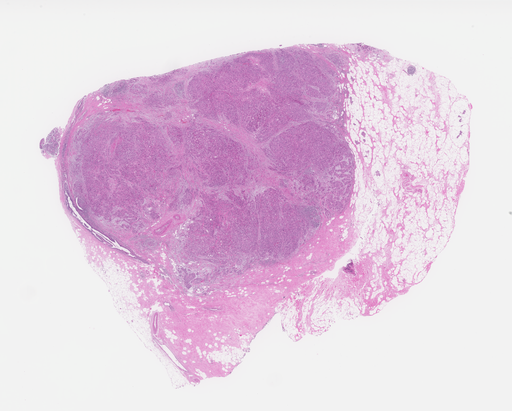

In [13]:
wsi = OpenSlide(DATA_ROOT + SLIDE_ID + ".svs")
wsi.get_thumbnail((512,512))

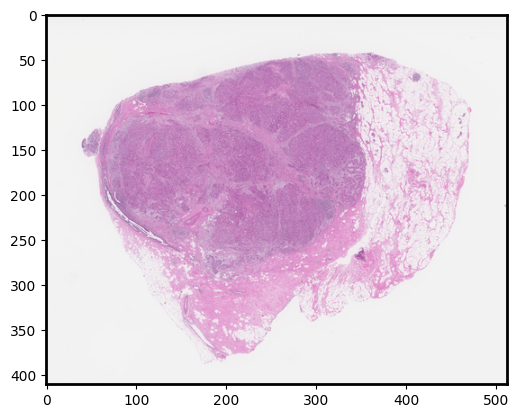

In [14]:
thumbnail  = wsi.get_thumbnail((512,512))
thumbnail = np.array(thumbnail)

fig, ax = plt.subplots()
ax.imshow(thumbnail)
ax.axis('on')
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
plt.show()

In [15]:
float(wsi.properties["openslide.mpp-x"]), float(wsi.properties["openslide.mpp-y"])

(0.2505, 0.2505)

In [16]:
wsi.dimensions

(69128, 55582)

In [17]:
wsi.level_count

4

In [18]:
wsi.level_dimensions

((69128, 55582), (17282, 13895), (4320, 3473), (2160, 1736))

In [19]:
wsi.level_downsamples

(1.0, 4.000071968333933, 16.00294147444306, 32.01049240484724)

### corrected mask after debugging

In [20]:
def load_h5_file(filename):
    with h5py.File(filename, "r") as f:
        coords = f['coords'][()]
        patch_level = f['coords'].attrs['patch_level']
        patch_size = f['coords'].attrs['patch_size']
        return coords, patch_level, patch_size

In [ ]:
coords, patch_level, patch_size = load_h5_file("<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/patch_extraction_data_224/maskwsi_processed_level4_224_fp/" + SLIDE_ID + ".h5")

In [22]:
coords.shape, patch_level, patch_size

((155, 2), 2, 224)

In [23]:
coords.min(0), coords.max(0)

(array([3584, 3584]), array([60928, 50176]))

## Check maskWSI

In [24]:
patch_size = conf_preproc.patch_size
patch_level = conf_preproc.patch_level

patch_size, patch_level

(224, 2)

In [25]:
mask_wsi_fp = MaskWSI_fp( DATA_ROOT + SLIDE_ID + ".svs", patch_level, predefined_mask_dir=None, macenko=False)

Calculating mask...
Resolution of image to extract: (4320, 3473)
Current mask level: 3
Mask image shape: (1736, 2160, 3)
Target white on current image: 235.0
Scale factor: 112
Image at mask level after crop:  (1680, 2128, 3)
scale factor: 112 width: 19 height: 15
Mask downsample image shape: (15, 19, 3) 217.98479532163742


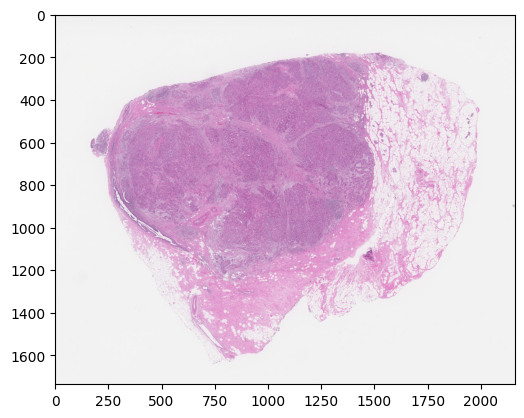

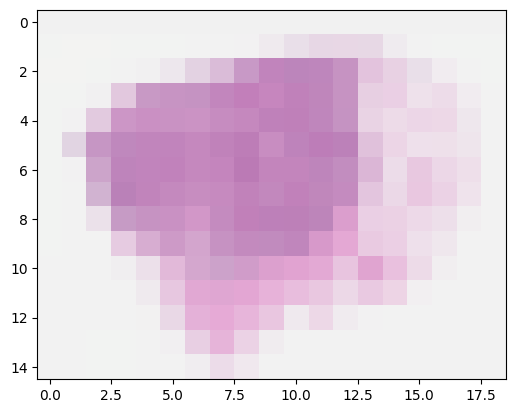

In [26]:
mask, w, h, image_mask_level_crop, scale_factor = mask_wsi_fp.get_mask(patch_size, mask_extrapolate=False, load_mask=False, ADAPT=-1, verbose=1)

In [27]:
mask.shape

(155, 2)

In [28]:
w,h

(19, 15)

In [29]:
image_mask_level_crop.shape, scale_factor

((1680, 2128, 3), 112)

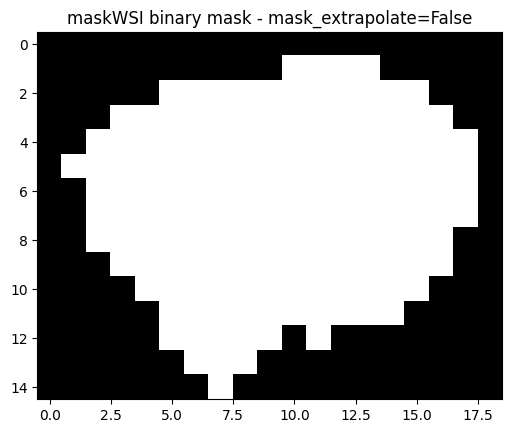

In [30]:
max_row = h
max_col = w

image = np.zeros((max_row, max_col), dtype=int)

for coord in mask:
    image[coord[0], coord[1]] = 1

plt.figure(figsize=(6, 6)) 
plt.imshow(image, cmap='gray')
plt.title('maskWSI binary mask - mask_extrapolate=False')
plt.show()

In [31]:
PATCH_SIZE = patch_size
LEVEL = patch_level

In [32]:
#coords = np.vstack( (mask[:,1], mask[:,0]) ).T*PATCH_SIZE*4**LEVEL #  coords should be given on level0 !

coords = np.vstack( (mask[:,1], mask[:,0]) ).T*PATCH_SIZE*int(wsi.level_downsamples[ patch_level ])     #  coords should be given on level0 !

In [33]:
wsi.level_downsamples

(1.0, 4.000071968333933, 16.00294147444306, 32.01049240484724)

In [34]:
coords.shape

(155, 2)

In [35]:
coords.min(0), coords.max(0)

(array([3584, 3584]), array([60928, 50176]))

In [36]:
coords_v3 = filter_patches_by_tissue_presence_improved(DATA_ROOT + SLIDE_ID + ".svs", 
                                                      coords, 
                                                      level=2,
                                                      patch_size=(224, 224),
                                                      save_patches=False, 
                                                      save_dir=None)

In [37]:
coords_v3.shape

(155, 2)

### Visualize binary mask

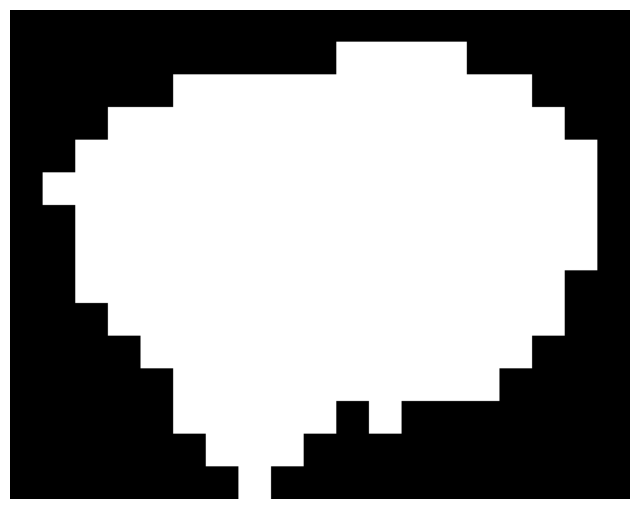

In [38]:
H, W = 2*image_mask_level_crop.shape[0], 2*image_mask_level_crop.shape[1]  # *2 as the mask from .get mask is on level 3, *2 maskes the mask on level 2

s = scale_factor*2  # scale_factor therefore is 112*2 as the scale_factor*numbers in mask should be the coord of 224x224 patches on level 2

# Build low-res binary mask (22x24)
low = np.zeros((h, w), dtype=np.uint8)
low[mask[:, 0], mask[:, 1]] = 1

# Upsample to full resolution (2464x2688)
high = np.kron(low, np.ones((s, s), dtype=np.uint8))  # shape (h*s, w*s)

# If dimensions might not match perfectly, crop/pad (usually unnecessary here)
high = high[:H, :W]

plt.figure(figsize=(8, 8))
plt.imshow(high, cmap="gray")
plt.axis("off")

plt.savefig(f"paper_figures/{SLIDE_ID}_level_2_seg_mask.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.savefig(f"paper_figures/{SLIDE_ID}_level_2_seg_mask.svg", bbox_inches="tight", pad_inches=0)

plt.show()


### Visualize WSI

In [39]:
mask_level = 7 if wsi.level_count-1 >= 7 else wsi.level_count-1

img_cut = np.array(wsi.read_region((0, 0), mask_level - 1, (W, H)))   # mask level - 1 to read from level 2
img_cut.shape

(3360, 4256, 4)

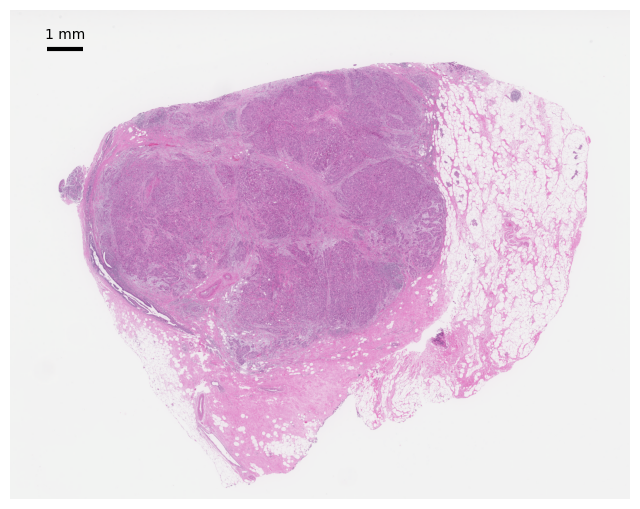

In [40]:
target_mm = 1.0
target_um = target_mm * 1000

mpp_x = float(wsi.properties["openslide.mpp-x"])
ds = wsi.level_downsamples[2]          # level 2 for your study
mpp_level = mpp_x * ds                  # µm/px at level 2

bar_px = int(np.round(target_um / mpp_level))  # pixels for 1 mm
label = "1 mm"


####
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_cut)
ax.axis("off")
#####

H, W = img_cut.shape[:2]

# Position (tune these)
x_left = 0.06   # fraction from left
y_top  = 0.92   # fraction from bottom (with imshow, this is still "near top" in axes coords)

# Convert 224 pixels to axes-fraction length
bar_len_ax = bar_px / W

# Full black scale bar
ax.plot([x_left, x_left + bar_len_ax], [y_top, y_top],
        transform=ax.transAxes, color="black", linewidth=3,
        solid_capstyle="butt", zorder=10)

# Black text above (no fill)
ax.text(x_left + bar_len_ax/2, y_top + 0.015, label,
        transform=ax.transAxes, ha="center", va="bottom",
        color="black", fontsize=10, zorder=11)


plt.savefig(f"paper_figures/{SLIDE_ID}_level_2.png", dpi=300, bbox_inches="tight",pad_inches=0)
plt.savefig(f"paper_figures/{SLIDE_ID}_level_2.svg", bbox_inches="tight", pad_inches=0)

plt.show()

### Visualize mask overlayed on tissue image

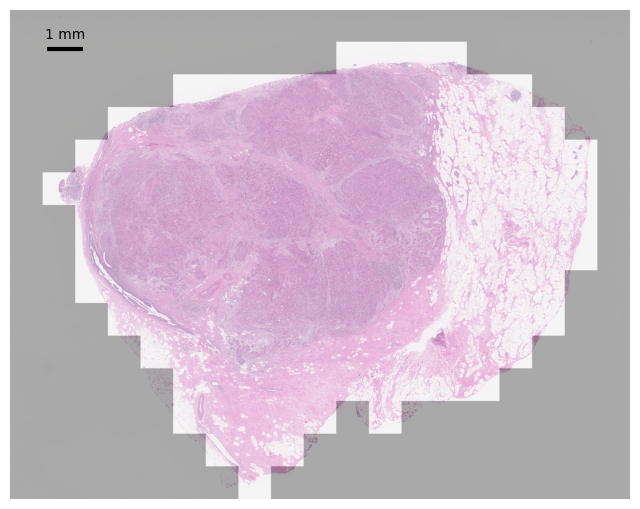

In [41]:
target_mm = 1.0
target_um = target_mm * 1000

mpp_x = float(wsi.properties["openslide.mpp-x"])
ds = wsi.level_downsamples[2]          # level 2 for your study
mpp_level = mpp_x * ds                  # µm/px at level 2

bar_px = int(np.round(target_um / mpp_level))  # pixels for 1 mm
label = "1 mm"

alpha = 0.3

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_cut)
ax.imshow(high, cmap="gray", alpha=alpha)
ax.axis("off")

H, W = img_cut.shape[:2]

x_left = 0.06
y_top  = 0.92

bar_len_ax = bar_px / W

ax.plot([x_left, x_left + bar_len_ax], [y_top, y_top],
        transform=ax.transAxes, color="black", linewidth=3,
        solid_capstyle="butt", zorder=10)

ax.text(x_left + bar_len_ax/2, y_top + 0.015, label,
        transform=ax.transAxes, ha="center", va="bottom",
        color="black", fontsize=10, zorder=11)

#plt.savefig(f"paper_figures/{SLIDE_ID}_level_2_mask_overlay.png", dpi=300, bbox_inches="tight", pad_inches=0)
#plt.savefig(f"paper_figures/{SLIDE_ID}_level_2_mask_overlay.svg", bbox_inches="tight", pad_inches=0)

plt.show()

### Visualize mask overlayed on tissue image - black and transparent

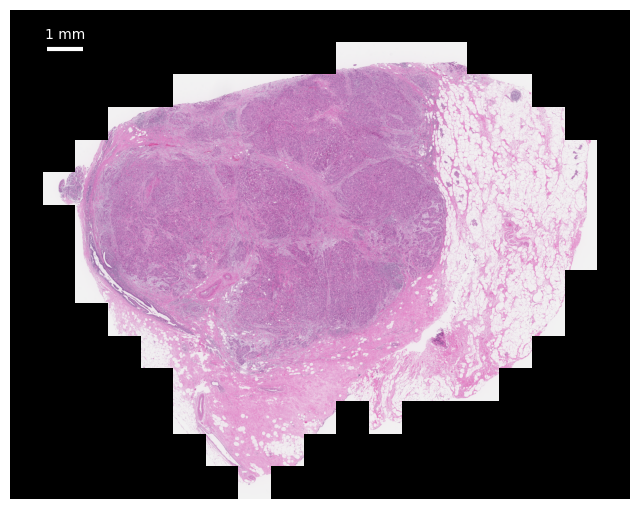

In [42]:
target_mm = 1.0
target_um = target_mm * 1000

mpp_x = float(wsi.properties["openslide.mpp-x"])
ds = wsi.level_downsamples[2]          # level 2 for your study
mpp_level = mpp_x * ds                  # µm/px at level 2

bar_px = int(np.round(target_um / mpp_level))  # pixels for 1 mm
label = "1 mm"



mask2d = high
if mask2d.ndim == 3:
    mask2d = mask2d[..., 0]
mask2d = (mask2d > 0)  # True = tissue

H, W = mask2d.shape
rgba = np.zeros((H, W, 4), dtype=np.float32)

# We want black outside tissue
outside = ~mask2d

rgba[outside, 0:3] = 0.0   # black RGB
rgba[outside, 3]   = 1.0   # fully opaque outside

# Tissue stays fully transparent because alpha remains 0 there

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img_cut)
ax.imshow(rgba, interpolation="nearest")
ax.axis("off")

H, W = img_cut.shape[:2]

x_left = 0.06
y_top  = 0.92

bar_len_ax = bar_px / W

ax.plot([x_left, x_left + bar_len_ax], [y_top, y_top],
        transform=ax.transAxes, color="white", linewidth=3,
        solid_capstyle="butt", zorder=10)

ax.text(x_left + bar_len_ax/2, y_top + 0.015, label,
        transform=ax.transAxes, ha="center", va="bottom",
        color="white", fontsize=10, zorder=11)

plt.savefig(f"paper_figures/{SLIDE_ID}_level_2_mask_overlay.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.savefig(f"paper_figures/{SLIDE_ID}_level_2_mask_overlay.svg", bbox_inches="tight", pad_inches=0)

plt.show()

### Visualize patch grid

In [43]:
wsi_path = DATA_ROOT + SLIDE_ID + ".svs"
wsi = OpenSlide(wsi_path)

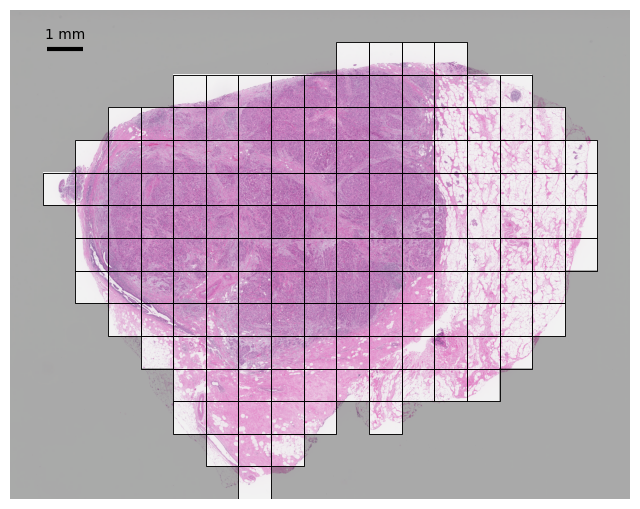

In [44]:
patchlev = 0 # as patch coords readed in are level 0 coords
vislev = 2 #3 # tricky to visualise on level 3 as the downscale factors are not constanc across the levels!

img_to_vis = np.array(wsi.read_region((0,0), vislev, (img_cut.shape[1], img_cut.shape[0]) ).convert("RGB"))

#fig = plt.figure(figsize=(8, 8), dpi=200)

#fig = plt.figure(figsize=(wsi.level_dimensions[vislev][0]/400, wsi.level_dimensions[vislev][1]/400), dpi=200)
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)


coords_viz =  coords_v3 // int(wsi.level_downsamples[vislev]) # bring coords to vislev

patch_scale_factor = int(wsi.level_downsamples[vislev]) // int(wsi.level_downsamples[patch_level]) # bring patch size to vislev


ax.plot([x_left, x_left + bar_len_ax], [y_top, y_top],
        transform=ax.transAxes, color="black", linewidth=3,
        solid_capstyle="butt", zorder=10)

ax.text(x_left + bar_len_ax/2, y_top + 0.015, label,
        transform=ax.transAxes, ha="center", va="bottom",
        color="black", fontsize=10, zorder=11)


for idx, c in enumerate(coords_viz):

    rect = patches.Rectangle((c[0], c[1]), ( PATCH_SIZE // patch_scale_factor),
                          ( PATCH_SIZE // patch_scale_factor ),  
                          facecolor="none", edgecolor='black', linestyle='-', linewidth=0.65)


    ax.add_patch(rect)
    
    # Add patch number as text in the top left corner of the rectangle
    #ax.text(c[0], c[1]+(PATCH_SIZE//2**(vislev-patchlev)), str(idx), fontsize=5, color='black', weight='bold')

    # Add coords
    # commented out because plot is too crowded
    #ax.text(c[0], c[1], f'({c[0]},{c[1]})', fontsize=8, color='blue')


ax.imshow(img_to_vis)


#### add transparent mask

mask2d = high
if mask2d.ndim == 3:
    mask2d = mask2d[..., 0]
mask2d = (mask2d > 0)  # True = tissue

H, W = mask2d.shape
rgba = np.zeros((H, W, 4), dtype=np.float32)

# We want black outside tissue
outside = ~mask2d

rgba[outside, 0:3] = 0.0   # black RGB
rgba[outside, 3]   = 0.3   # tranparency outside tissue
ax.imshow(rgba, interpolation="nearest")
####


ax.axis('off')

plt.savefig(f"paper_figures/{SLIDE_ID}_level_2_patch_grid.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.savefig(f"paper_figures/{SLIDE_ID}_level_2_patch_grid.svg", bbox_inches="tight", pad_inches=0)

### Visualize one 224x224 patch at 10x, and one patch of that from 40x

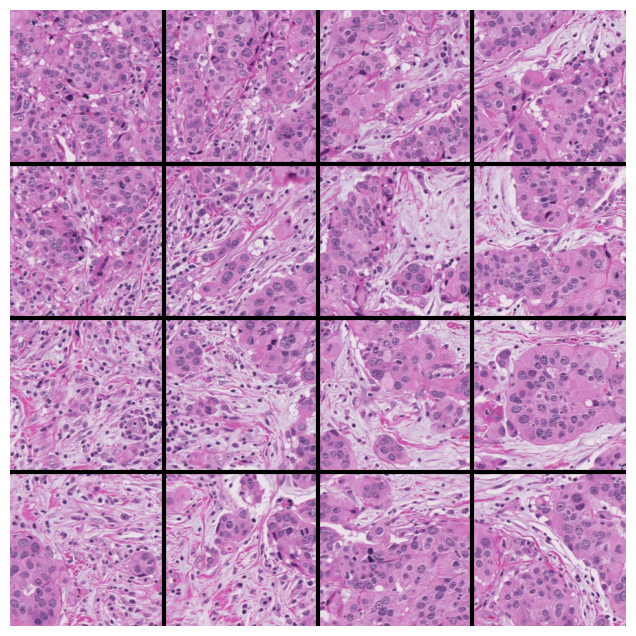

In [45]:
vislev = 1

# read one 224x224 patch at 10x (level 1)
patch_10x = np.array(wsi.read_region(coords_v3[72], vislev, (224*4, 224*4)).convert("RGB")) # 896x896


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.imshow(patch_10x)
ax.axis('off')


H, W = patch_10x.shape[:2]
step_x = W // 4   # 224
step_y = H // 4   # 224

# Ensure axes coordinates match pixel coordinates
ax.set_xlim(0, W)
ax.set_ylim(H, 0)  # keep origin at top-left (imshow default look)

# Draw the 4x4 grid (3 internal lines each direction)
for i in range(1, 4):
    ax.axvline(i * step_x, color="black", linewidth=3.0, zorder=10)
    ax.axhline(i * step_y, color="black", linewidth=3.0, zorder=10)

plt.savefig(f"paper_figures/{SLIDE_ID}_level_1_10x_patch.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.savefig(f"paper_figures/{SLIDE_ID}_level_1_10x_patch.svg", bbox_inches="tight", pad_inches=0)

plt.show()

In [46]:
coords[72] + (3*(224*4*4) // 4), (1*(224*4*4) // 4)

(array([45696, 24192]), 896)

In [47]:
(3*(224*4*4) // 4), (1*(224*4*4) // 4)

(2688, 896)

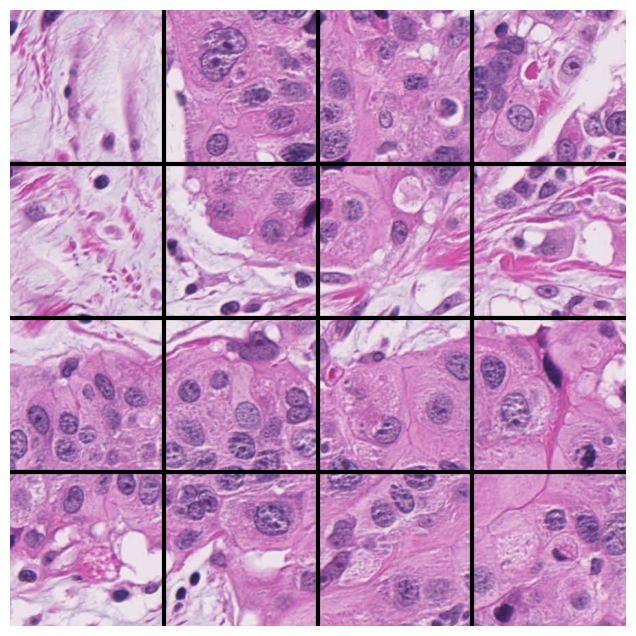

In [48]:
vislev = 0

# read one 224x224 patch at 40x (level 0)
patch_40x = np.array(wsi.read_region((coords_v3[72][0] + (3* 224*4), coords_v3[72][1] + (1*224*4)), vislev, (224*4, 224*4)).convert("RGB")) # 896x896


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

ax.imshow(patch_40x)
ax.axis('off')


H, W = patch_40x.shape[:2]
step_x = W // 4   # 224
step_y = H // 4   # 224

# Ensure axes coordinates match pixel coordinates
ax.set_xlim(0, W)
ax.set_ylim(H, 0)  # keep origin at top-left (imshow default look)

# Draw the 4x4 grid (3 internal lines each direction)
for i in range(1, 4):
    ax.axvline(i * step_x, color="black", linewidth=3.0, zorder=10)
    ax.axhline(i * step_y, color="black", linewidth=3.0, zorder=10)

plt.savefig(f"paper_figures/{SLIDE_ID}_level_0_40x_patch.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.savefig(f"paper_figures/{SLIDE_ID}_level_0_40x_patch.svg", bbox_inches="tight", pad_inches=0)

plt.show()